### Further clean SPEND & PAYMENT variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from itertools import compress
from pandarallel import pandarallel
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, print_percentile,
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
START = time.time()

### Read Data

In [7]:
%%time
train = read_file(f"../{RAW_TRAIN_PARQUET_PATH}/spend_payment.parquet")
test = read_file(f"../{RAW_TEST_PARQUET_PATH}/spend_payment.parquet")

Shape of data: (5531451, 26)
Shape of data: (11363762, 26)
CPU times: user 4.48 s, sys: 6.86 s, total: 11.3 s
Wall time: 10.9 s


In [8]:
%%time
labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 891 ms, sys: 497 ms, total: 1.39 s
Wall time: 1.84 s


In [9]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 3.05 s, sys: 1.85 s, total: 4.9 s
Wall time: 6.62 s


In [10]:
del test

In [11]:
train.shape, public_test.shape, private_test.shape

((5531451, 27), (5719469, 26), (5644293, 26))

In [12]:
print(sorted(get_cols(train, ["P_", "S_"])))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


In [13]:
train["target"].mean()

0.24909720794778803

In [14]:
df_list = [train, public_test, private_test]

In [15]:
for df in df_list:
    insert_row_number(df)

Done insertion
Done insertion
Done insertion


In [16]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
# train_corr = train.loc[:, train.columns[4:-1]].corr()
# train_corr.to_csv(f"../{RAW_DATA_PATH}/pre_clean_train_spend_payment_corr.csv", index=False)

In [18]:
train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_spend_payment_corr.csv")
train_corr.index = train_corr.columns

Shape of data: (24, 24)


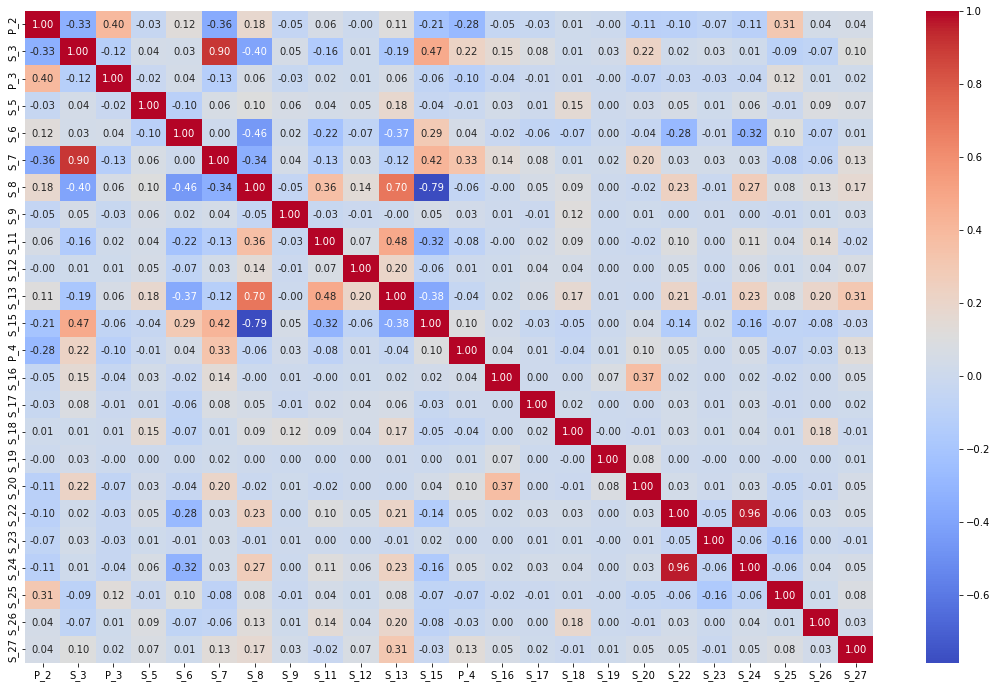

In [19]:
plot_heatmap(train_corr, figsize=(19, 12), fmt=".2f", annot=True)

### P_2 (Done)

In [20]:
# plot_target_check(train, "P_2", q=50, use_raw_bin=True)

In [21]:
%%time
df_list = round_dfs(df_list, col="P_2", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0205
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0045
CPU times: user 2.51 s, sys: 1.44 s, total: 3.95 s
Wall time: 5.73 s


In [22]:
describe_all(df_list, "P_2")

,train,public test,private test
count,"5,485,466.0000","5,685,852.0000","5,618,032.0000"
mean,0.6513,0.6501,0.6553
std,0.2447,0.2475,0.2463
min,-0.4600,-0.4400,-0.4700
25%,0.4800,0.4800,0.4900
50%,0.6900,0.6900,0.7000
75%,0.8600,0.8600,0.8600
max,1.0000,1.0000,1.0000
null_proportion,0.0083,0.0059,0.0047


In [23]:
print_percentile(df_list, "P_2", 0.0002)

0.0002th percentile:
train : -0.41
public test : -0.39628298
private test : -0.4


In [24]:
for df in df_list:
    df = clip_col(df, "P_2", btm_value=-0.4, add_new_col=False)

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1


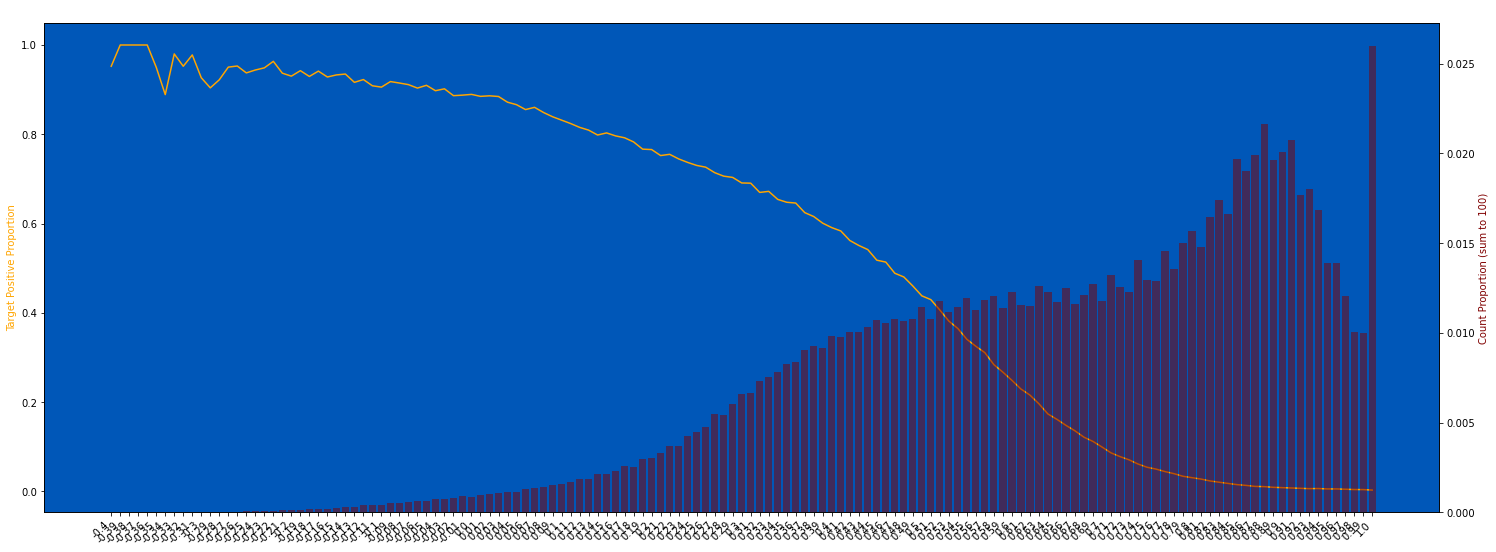

In [25]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True, nunique_thr=150, strfy_x=True, figsize=(25, 10), without_drop_tail=True)

In [26]:
# plot_train_test_distribution(df_list, "P_2", nunique_thr=150, figsize=(24, 9), without_drop_tail=True)

### P_3a (Created)

In [27]:
# for p in np.arange(2.8, 4, 0.05):
#     def calc(x):
#         if x >= 0.618:
#             return (x - 0.618) / p
#         else:
#             return (0.618 - x)

#     for df in df_list:
#         df["P_3a"] = df["P_3"].parallel_apply(lambda x: calc(x)).round(2)
        
#     print(p, check_roc_auc(train, "P_3a"))

In [28]:
def calc(x):
    p = 0.624
    q = 4
    if x >= p:
        return (x - p) / q
    else:
        return (p - x)

In [29]:
for df in df_list:
    df["P_3a"] = df["P_3"].parallel_apply(lambda x: calc(x)).round(2)
    df = clip_col(df, "P_3a", add_new_col=False, top_value=1)

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


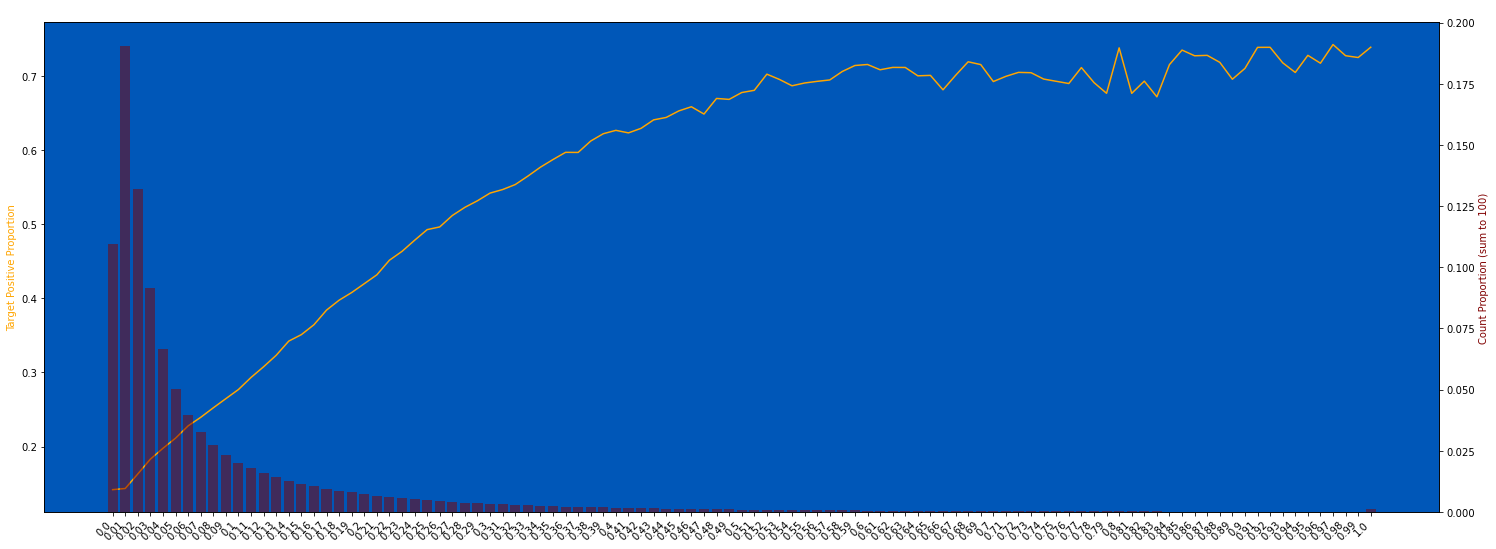

In [30]:
plot_target_check(train, "P_3a", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, 
                  figsize=(25, 10), without_drop_tail=True)

In [31]:
# plot_train_test_distribution(df_list, "P_3a", nunique_thr=340, figsize=(24, 10), without_drop_tail=True)

### P_3 (Done)

In [32]:
# plot_target_check(train, "P_3", q=50, use_raw_bin=True)

In [33]:
%%time
df_list = round_dfs(df_list, col="P_3", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0466
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0175
CPU times: user 2.68 s, sys: 1.27 s, total: 3.94 s
Wall time: 5.68 s


301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1
Top & Bottom 2% are dropped from this chart


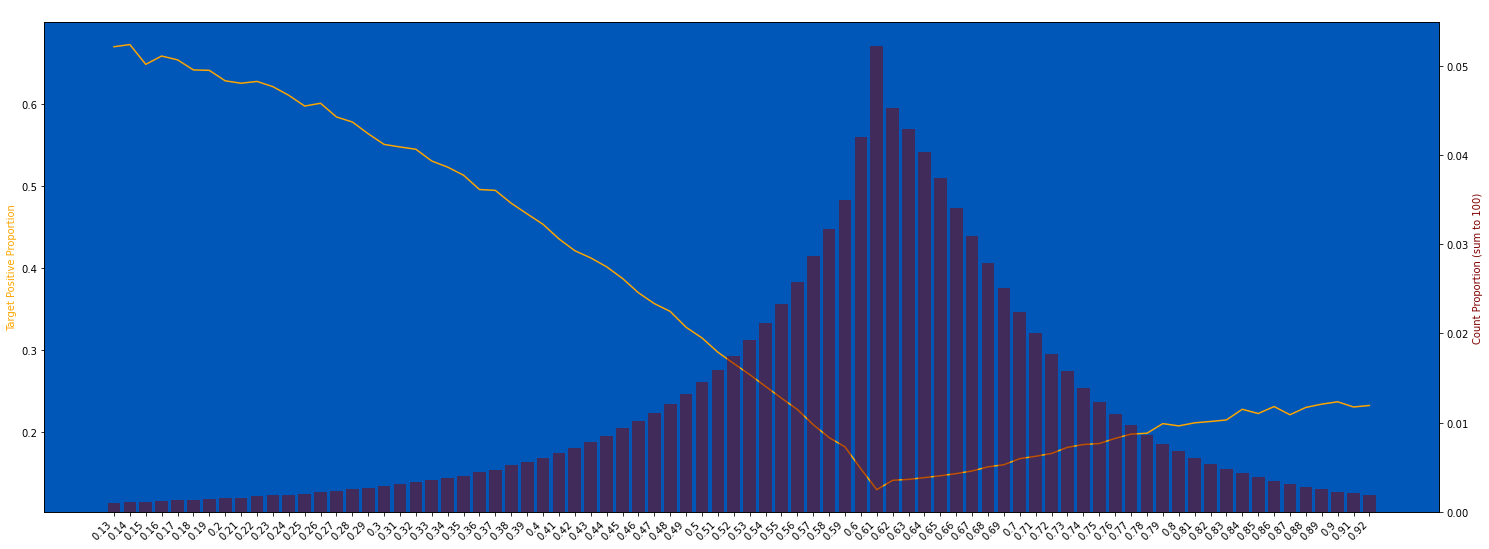

In [34]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, 
                  figsize=(25, 10), percentile_drop=2)

In [35]:
# plot_train_test_distribution(df_list, "P_3", nunique_thr=340, figsize=(24, 10))

### P_4 (KIV) Spike in the middle

In [36]:
# plot_target_check(train, "P_4", q=50, use_raw_bin=True)

In [37]:
%%time
df_list = round_dfs(df_list, col="P_4", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1472
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0955
CPU times: user 2.33 s, sys: 1.39 s, total: 3.71 s
Wall time: 5.15 s


In [38]:
# plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

**Comments:**
- P_4 in (0, 0.01) should be NaN, because it has different default trend + extremely low values (outlier)
- Also, original P_4 has no missing values

In [39]:
%%time
df_list = fill_nans(df_list, col="P_4", tuple_of_values=(0, 0.01), add_new_col=False)

CPU times: user 102 ms, sys: 81.1 ms, total: 183 ms
Wall time: 183 ms


4732506 null count, 0.856 null proportion
0.2073 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


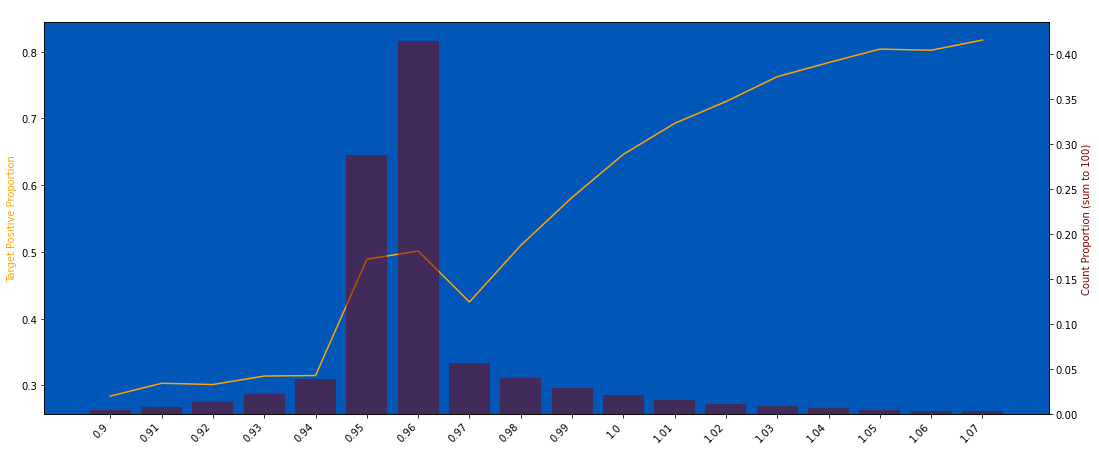

In [40]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

**ToDo:**
- Identify the subset of P_4 in (0.95, 0.96) to fill with other values, to fix
  - The spike in default trend & distribution bell curve

Train-Public PSI: 0.0609, Train-Private PSI: 0.0945


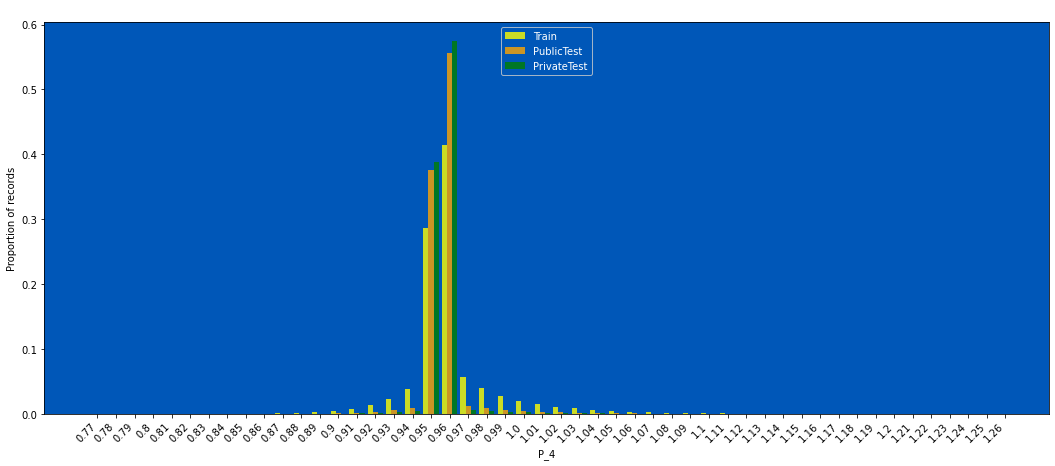

In [41]:
plot_train_test_distribution(df_list, "P_4", without_drop_tail=True)

### S_3a (Created)

In [42]:
# plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True, percentile_drop=0.05)

In [43]:
describe_all(df_list, "S_3")

,train,public test,private test
count,"4,510,907.0000","4,794,690.0000","4,828,107.0000"
mean,0.2258,0.2297,0.2251
std,0.1933,0.2005,0.1971
min,-0.6271,-0.6856,-0.6562
25%,0.1273,0.1272,0.1258
50%,0.1639,0.1648,0.1637
75%,0.2581,0.2665,0.2575
max,5.4829,4.1503,4.3412
null_proportion,0.1845,0.1617,0.1446


In [44]:
for df in df_list:
    # df["S_3a"] = df["S_3"].parallel_apply(lambda x: manual_stack(x, start=0.18, stack_interval=0.05, denom=100))
    df["S_3a"] = pd.qcut(df["S_3"], q=100).cat.codes.replace(-1, np.nan)

In [45]:
# plot_target_check(train, "S_3a", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True, percentile_drop=0.05)

In [46]:
# plot_train_test_distribution(df_list, "S_3a", nunique_thr=1000)

### S_3 (Done)

In [47]:
# plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [48]:
%%time
df_list = round_dfs(df_list, col="S_3", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0690
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0480
CPU times: user 2.32 s, sys: 1.33 s, total: 3.64 s
Wall time: 4.98 s


In [49]:
# plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True, percentile_drop=0.5)

Train-Public PSI: 0.0413, Train-Private PSI: 0.0480
Bottom 1% and Top 1% are dropped from this chart


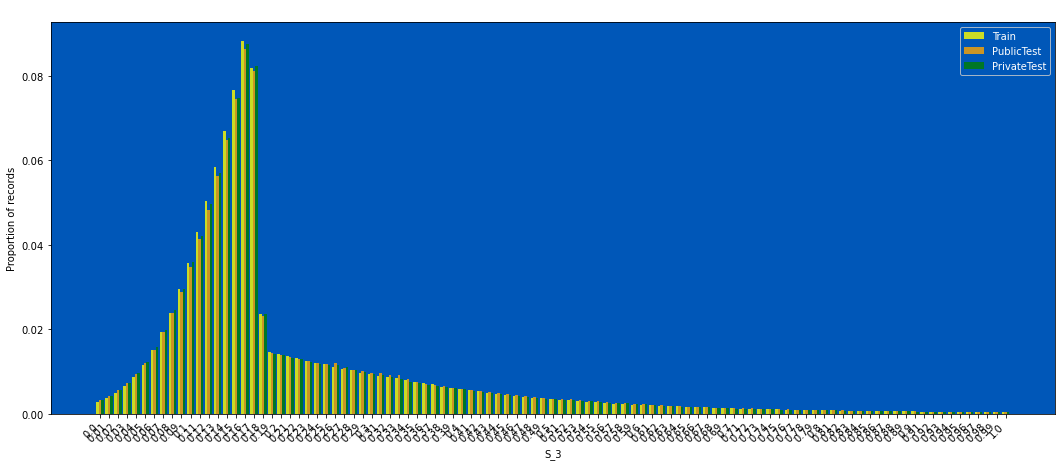

In [50]:
plot_train_test_distribution(df_list, "S_3", nunique_thr=500)

### S_5 (Done)

In [51]:
# plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [52]:
%%time
df_list = round_dfs(df_list, col="S_5", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0705
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0706
CPU times: user 2.36 s, sys: 1.07 s, total: 3.43 s
Wall time: 4.83 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


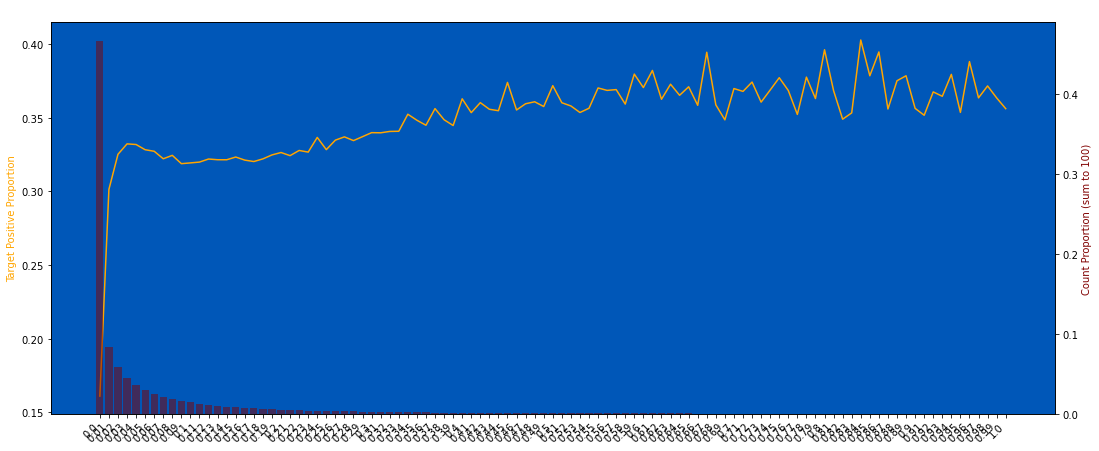

In [53]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [54]:
def get_weird_cid_list_s5(df):
    c = df.groupby("customer_ID")["S_5"].agg(["max", "min", "mean", "std"]).reset_index()
    sozi_cid_list1 = c[c["max"] == 0].customer_ID.tolist()
    # sozi_cid_list2 = c.loc[(c["min"] < 0.1) & (c["max"].between(0.17, 0.19))].customer_ID.tolist()
    # sozi_cid_list = sozi_cid_list1 + sozi_cid_list2
    return sozi_cid_list1, c

In [55]:
for df in tqdm(df_list):
    sozi_cid_list, _ = get_weird_cid_list_s5(df)
    df.loc[(df["customer_ID"].isin(sozi_cid_list)) & (df["S_5"] == 0), "S_5"] = np.nan

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


1398133 null count, 0.253 null proportion
0.0846 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


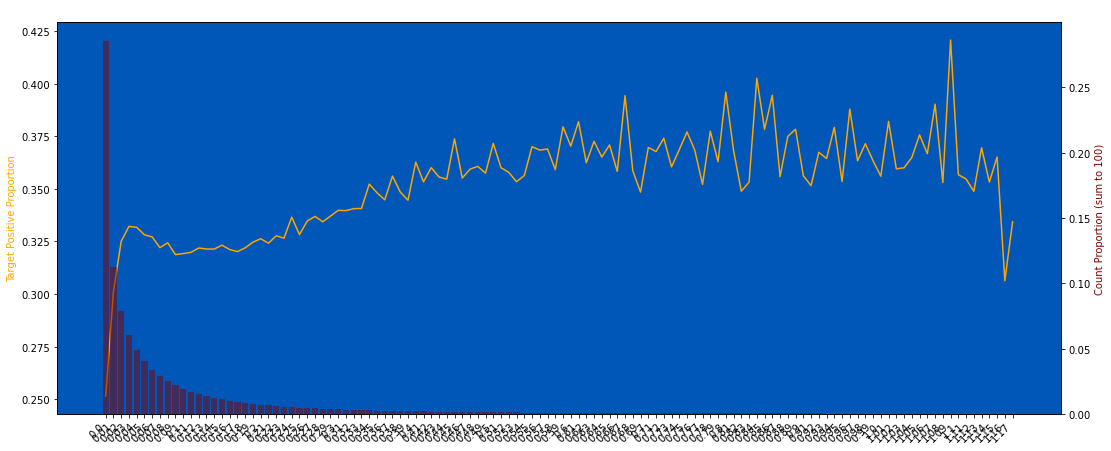

In [56]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0680, Train-Private PSI: 0.0717
Bottom 1% and Top 1% are dropped from this chart


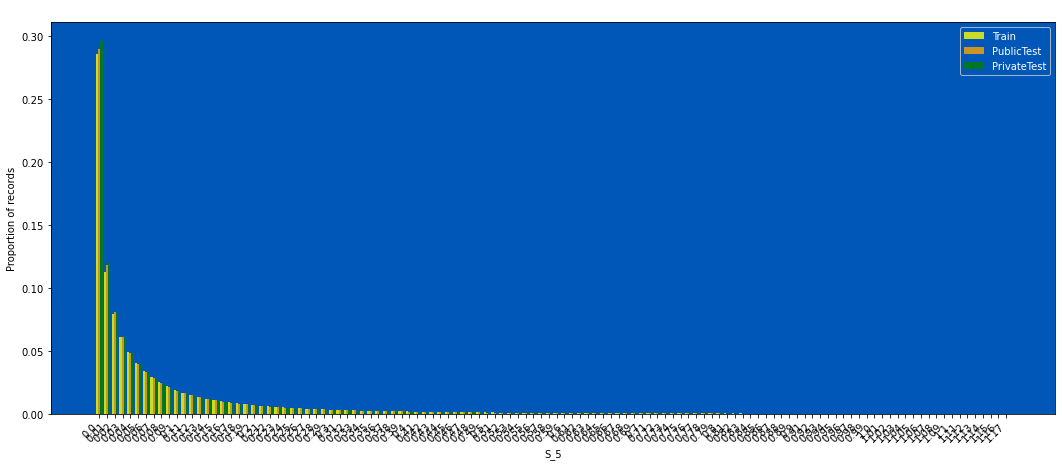

In [57]:
plot_train_test_distribution(df_list, "S_5", nunique_thr=5000)

### S_6 (Done)

In [58]:
# plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True)

In [59]:
%%time
df_list = round_dfs(df_list, col="S_6", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0118
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0118
CPU times: user 2.26 s, sys: 1.42 s, total: 3.68 s
Wall time: 5.48 s


In [60]:
# plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [61]:
for df in df_list:
    df["S_6"] = integerize(df["S_6"])

In [62]:
# plot_train_test_distribution(df_list, "S_6", nunique_thr=50)

### S_7a (Created)

In [63]:
describe_all(df_list, "S_7")

,train,public test,private test
count,"4,510,907.0000","4,794,690.0000","4,828,107.0000"
mean,0.2231,0.2189,0.2108
std,0.2063,0.2051,0.1982
min,-0.4701,-0.5101,-0.4888
25%,0.0937,0.0924,0.0913
50%,0.1397,0.1351,0.1275
75%,0.2955,0.2882,0.2754
max,3.9483,3.3929,3.3998
null_proportion,0.1845,0.1617,0.1446


In [64]:
for df in tqdm(df_list):
    df["S_7a"] = pd.qcut(df["S_7"], q=100).cat.codes.replace(-1, np.nan)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


In [65]:
# plot_target_check(train, "S_7a", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True, percentile_drop=0.05)

In [66]:
# plot_train_test_distribution(df_list, "S_7a", nunique_thr=1000)

### S_7 (Done)

In [67]:
# plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [68]:
%%time
df_list = round_dfs(df_list, col="S_7", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0676
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0359
CPU times: user 2.3 s, sys: 1.13 s, total: 3.43 s
Wall time: 4.99 s


In [69]:
# plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

Train-Public PSI: 0.0297, Train-Private PSI: 0.0359
Bottom 1% and Top 1% are dropped from this chart


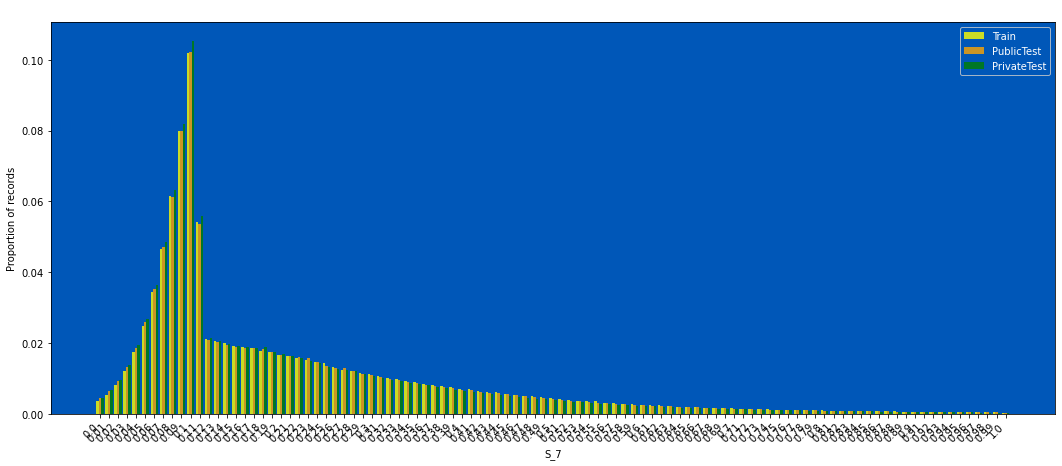

In [70]:
plot_train_test_distribution(df_list, "S_7", nunique_thr=5000)

### S_8 (KIV)

In [71]:
# plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [72]:
%%time
df_list = round_dfs(df_list, col="S_8", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0181
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0177
CPU times: user 2.74 s, sys: 1.9 s, total: 4.64 s
Wall time: 9.8 s


In [73]:
# plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

**Comments**
- S_8 in (0, 0.01) is likely to be NaN, because it violates the default rate downward trend & its average default rate is around 25%
- Also, original S_8 has no null values

In [74]:
%%time
df_list = fill_nans(df_list, col="S_8", tuple_of_values=(0), add_new_col=False)

CPU times: user 81.7 ms, sys: 62 ms, total: 144 ms
Wall time: 173 ms


1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1


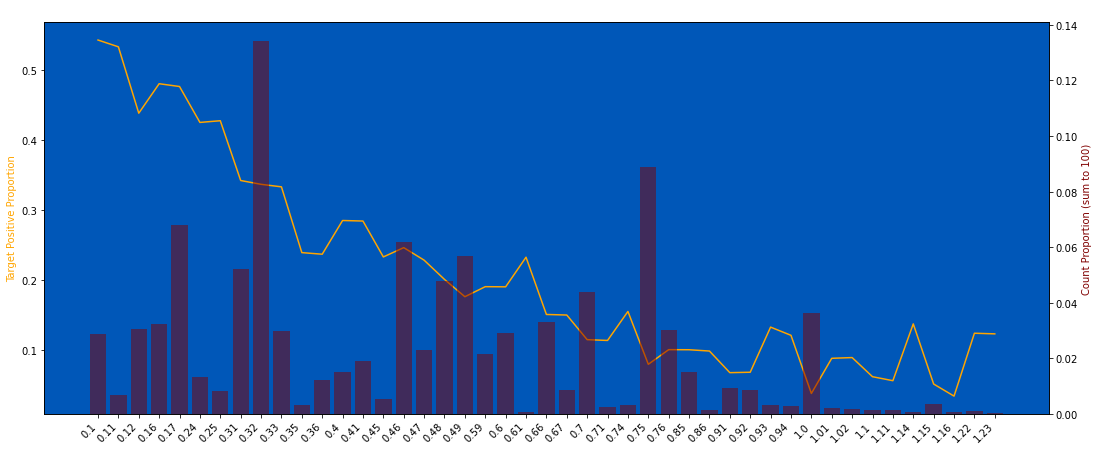

In [75]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0068, Train-Private PSI: 0.0140


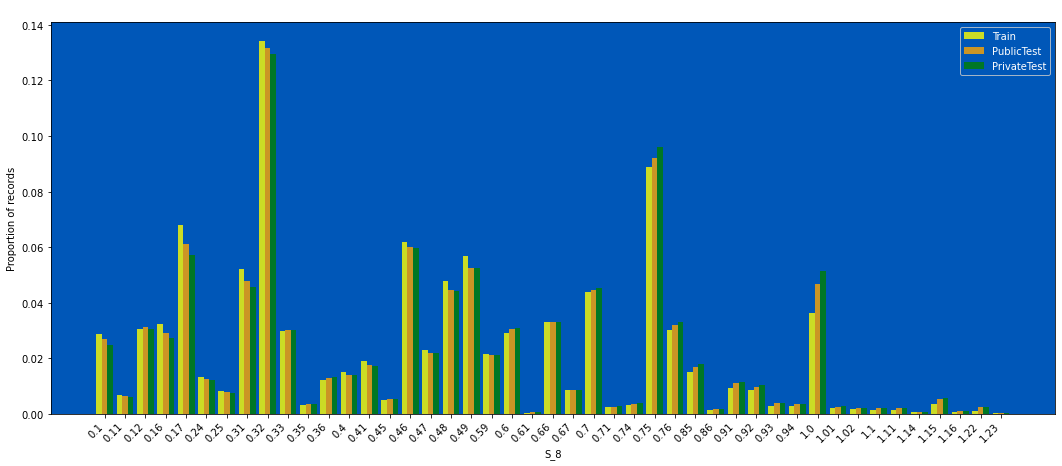

In [76]:
plot_train_test_distribution(df_list, "S_8", nunique_thr=500, without_drop_tail=True)

### S_9 (Drop)

In [77]:
# plot_target_check(train, "S_9", q=50, use_raw_bin=True)

In [78]:
df_list = round_dfs(df_list, col="S_9", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.2505
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.2401


Train-Public PSI: 0.0534, Train-Private PSI: 0.2401
Bottom 1% and Top 1% are dropped from this chart


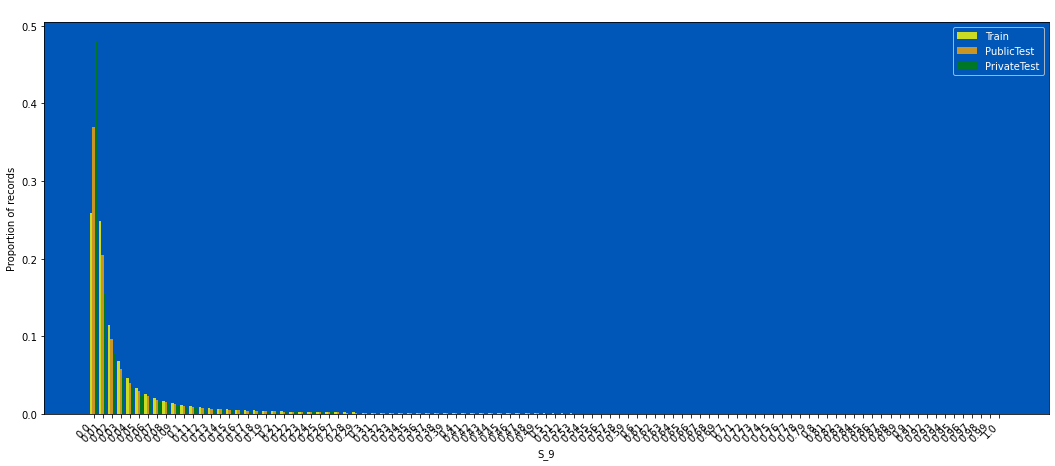

In [79]:
plot_train_test_distribution(df_list, "S_9", nunique_thr=300)

In [80]:
for df in tqdm(df_list):
    df.drop(columns="S_9", errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.49it/s]


### S_11 (Drop)

In [81]:
# plot_target_check(train, "S_11", q=50, use_raw_bin=True)

In [82]:
df_list = round_dfs(df_list, col="S_11", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 1.2048
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 1.1845


In [83]:
# plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [84]:
for df in df_list:
    df["S_11_"] = (df["S_11"] / 0.04).round(0)

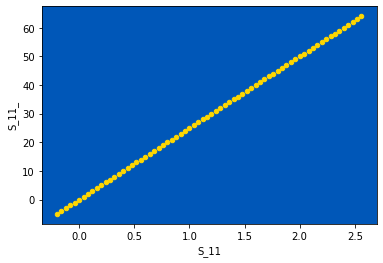

In [85]:
check_binning(train, "S_11", end=70)

In [86]:
for df in df_list:
    df["S_11"] = (df["S_11"] / 0.04).round(0)

In [87]:
# s11_min_max_df = train.groupby("customer_ID").agg(
#     s11_max=("S_11", "max"), 
#     s11_min=("S_11", "min")
# )
# t = s11_min_max_df.loc[s11_min_max_df["s11_max"] == s11_min_max_df["s11_min"]]
# sus_cid_list = t.loc[t["s11_max"] == 7].index.tolist()
# train.loc[train["customer_ID"].isin(sus_cid_list), "S_11"] = np.nan

0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


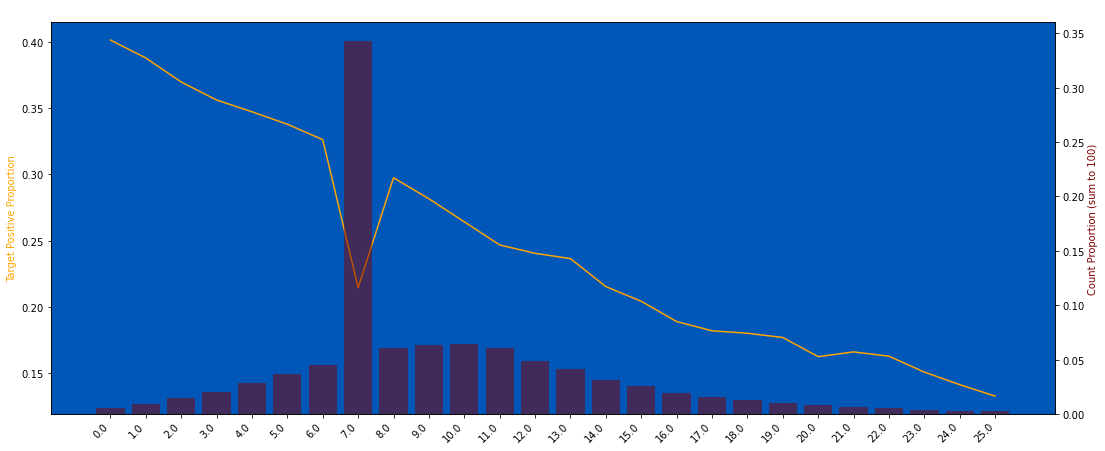

In [88]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.9825, Train-Private PSI: 1.1845
Bottom 1% and Top 1% are dropped from this chart


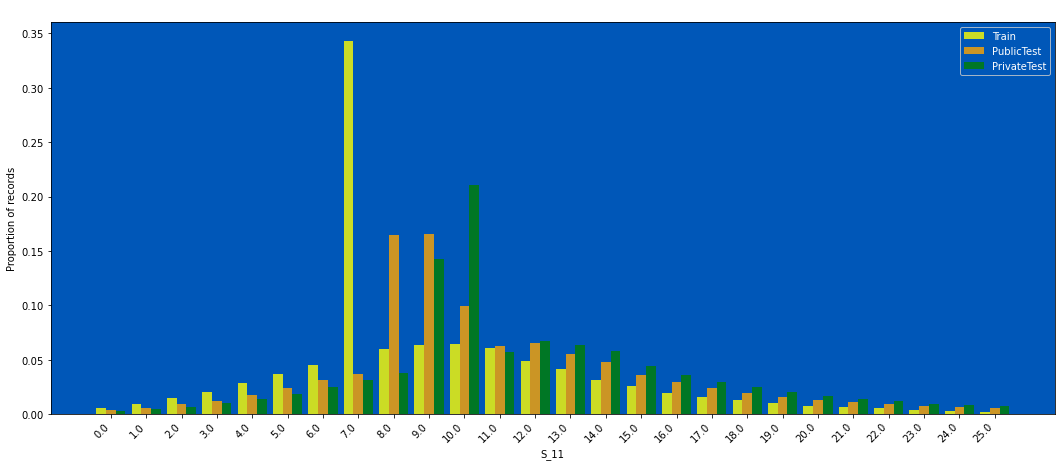

In [89]:
plot_train_test_distribution(df_list, "S_11", nunique_thr=50000)

**Train Test Skew: Heavy**

**ToDo:**
- Identify subset of 7 - 10 to be replace by other values to fix the train test skew & make the bell curve smoother
- If not able to do that, drop this column S_11

### S_12

In [90]:
# plot_target_check(train, "S_12", q=50, use_raw_bin=True)

In [91]:
%%time
df_list = round_dfs(df_list, col="S_12", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0513
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0500
CPU times: user 2.65 s, sys: 1.03 s, total: 3.68 s
Wall time: 4.25 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


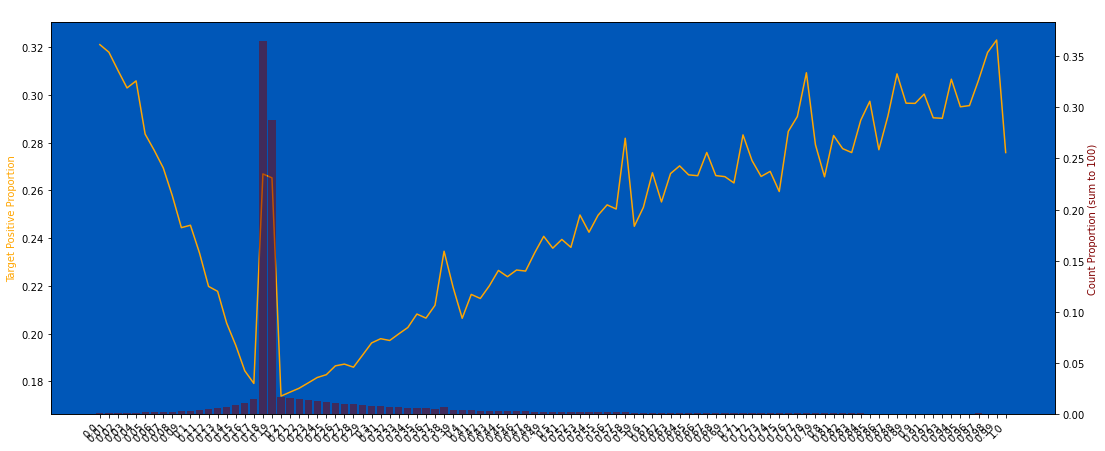

In [92]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

#### ToDo:
- Replace some of the 0.18 & 0.19 with NaN, need to find the appropriate way to filter the subset to be replace

Train-Public PSI: 0.0444, Train-Private PSI: 0.0500
Bottom 1% and Top 1% are dropped from this chart


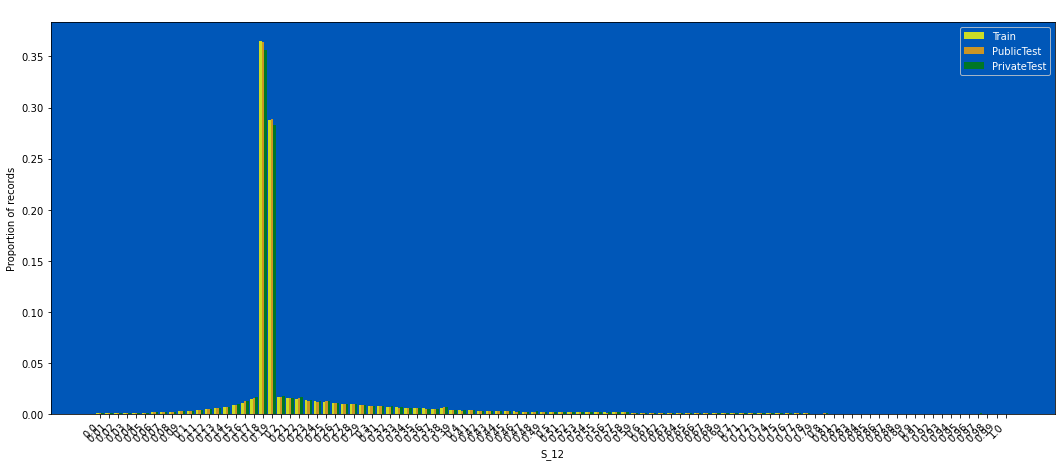

In [93]:
plot_train_test_distribution(df_list, "S_12", nunique_thr=50000)

**Train Test Skew: Mild**

### S_13

In [94]:
# plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

In [95]:
%%time
df_list = round_dfs(df_list, col="S_13", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1197
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1181
CPU times: user 2.21 s, sys: 1.13 s, total: 3.34 s
Wall time: 4.27 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


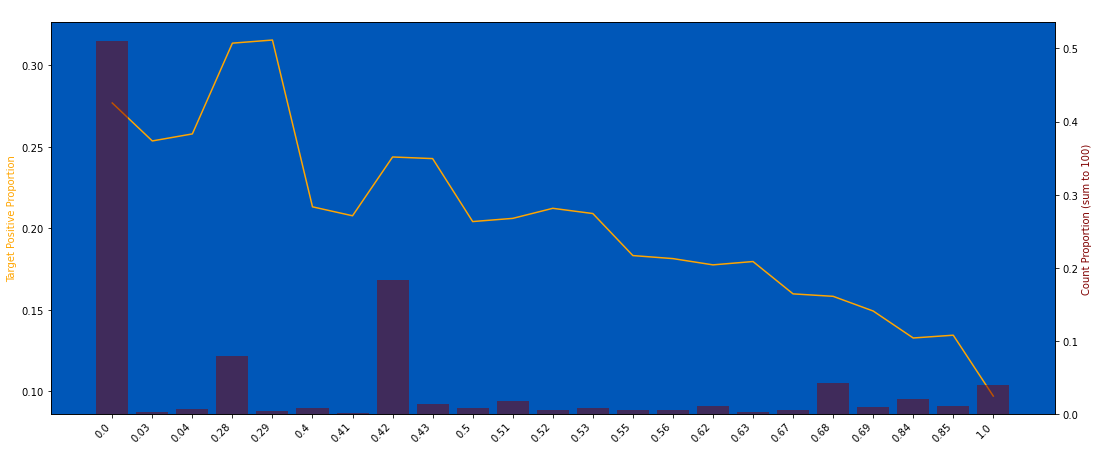

In [96]:
plot_target_check(train, "S_13", q=120, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [97]:
mapping_dict = {0.03: 1, 0.04: 1, 0.28: 2, 0.29: 2, 0.4 : 3, 0.41: 3, 0.42: 4, 0.43: 4, 
                0.5 : 5, 0.51: 5, 0.52: 6, 0.53: 6, 0.55: 7, 0.56: 7, 0.62: 8, 0.63: 8, 
                0.67: 9, 0.68: 9, 0.69: 10, 0.84: 11, 0.85: 11, 1: 12}

In [100]:
for df in df_list:
    df["S_13"] = df["S_13"].map(mapping_dict)

2822865 null count, 0.510 null proportion
0.2769 of the targets have label = 1


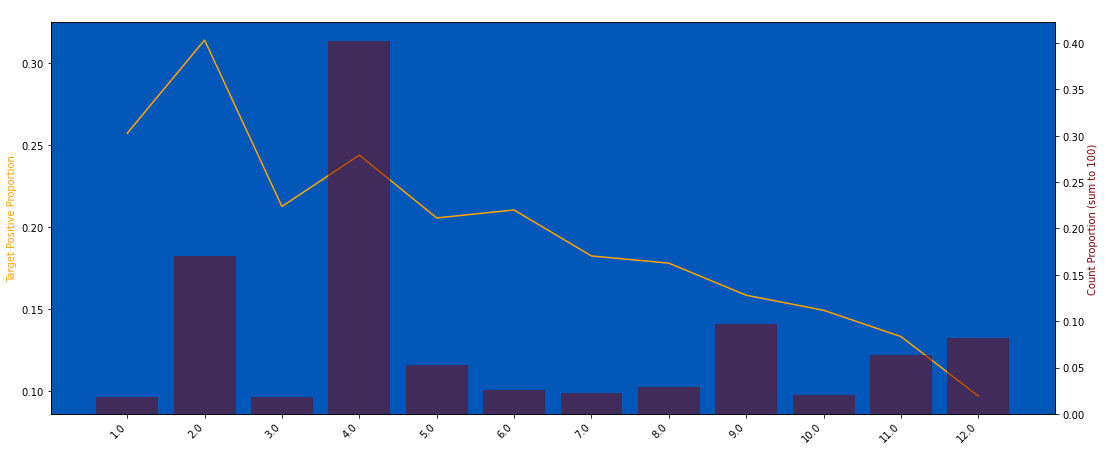

In [101]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0373, Train-Private PSI: 0.0891
Bottom 1% and Top 1% are dropped from this chart


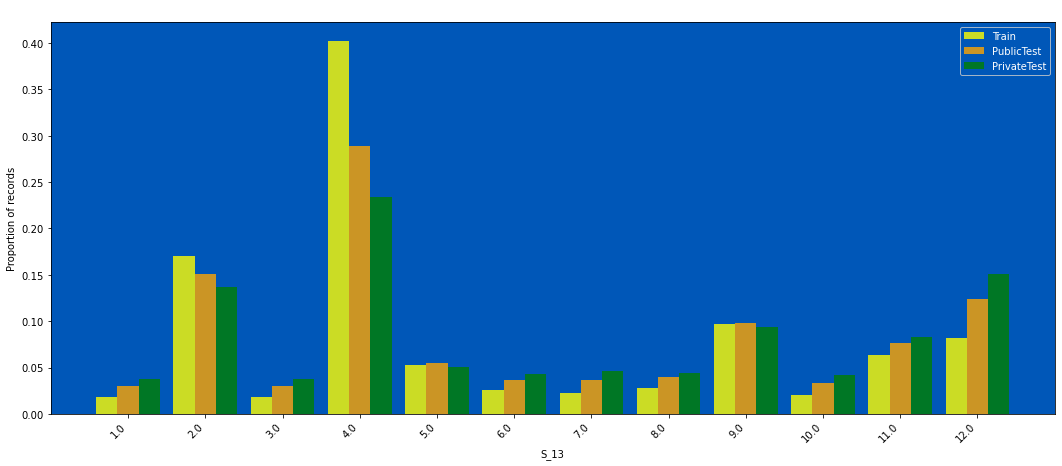

In [102]:
plot_train_test_distribution(df_list, "S_13", nunique_thr=50000)

**Train Test Skew: Heavy**

### S_15 (Fix)

In [103]:
# plot_target_check(train, "S_15", q=50, use_raw_bin=True)

In [104]:
%%time
df_list = round_dfs(df_list, col="S_15", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.3584
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.3534
CPU times: user 2.57 s, sys: 1.03 s, total: 3.6 s
Wall time: 4.12 s


In [105]:
# plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

**Comments:**
- Some of the 0.5 - 0.51 are suspiciously null value, reason => violate bell curve & spike in default trend (lower default rate)

In [106]:
# for df in df_list:
#     df.loc[df["S_15"].between(0.5, 0.51), "S_15"] = np.nan

In [107]:
# for col in train.columns[2:]:
#     if col == "temp":
#         continue
#     corrcoef = train[["S_15_", col]].dropna().corr().iloc[0, 1]
#     if abs(corrcoef) >= 0.3:
#         print(col, corrcoef)

**Comments:**
- S_8 has the highest (absolute) correlation with S_15, use this information to cross validate the 0.5 - 0.51

In [108]:
train["S_8"].describe()

count   3,722,971.0000
mean            0.4793
std             0.2477
min             0.1000
25%             0.3200
50%             0.4600
75%             0.7000
max             1.2300
Name: S_8, dtype: float64

In [109]:
train.loc[train["S_8"].isnull(), "S_15"].describe()

count   1,808,480.0000
mean            0.5212
std             0.1140
min             0.5000
25%             0.5000
50%             0.5000
75%             0.5000
max             5.3000
Name: S_15, dtype: float64

In [110]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 0)

0.5

In [111]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 95)

0.6

**Comments:**
- When S_8 is null, S_15 is likely to be 0.5 (about 93% of them)
- Replace those S_15 (0.5 - 0.51) with NaN

In [112]:
for df in df_list:
    df.loc[df["S_8"].isnull(), "S_15"] = np.nan

In [113]:
for df in df_list:
    df["S_15"] = df["S_15"].abs()

In [114]:
for df in df_list:
    df = clip_col(df, "S_15", top_value=2.8, add_new_col=False)

1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1


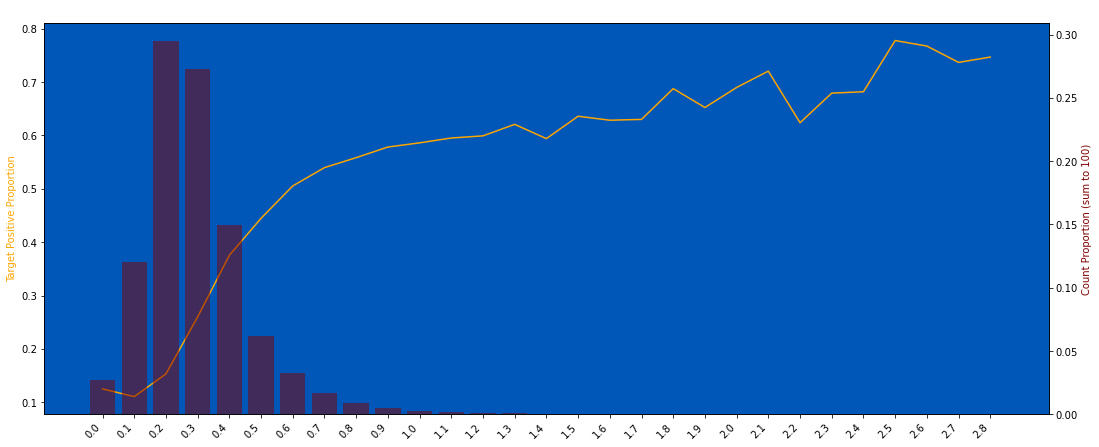

In [115]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [116]:
describe_all(df_list, "S_15")

,train,public test,private test
count,"3,722,971.0000","3,948,039.0000","3,990,462.0000"
mean,0.2981,0.2862,0.2801
std,0.1797,0.1807,0.1795
min,0.0000,0.0000,0.0000
25%,0.2000,0.2000,0.2000
50%,0.3000,0.3000,0.3000
75%,0.4000,0.4000,0.4000
max,2.8000,2.8000,2.8000
null_proportion,0.3269,0.3097,0.2930


Train-Public PSI: 0.0065, Train-Private PSI: 0.0137


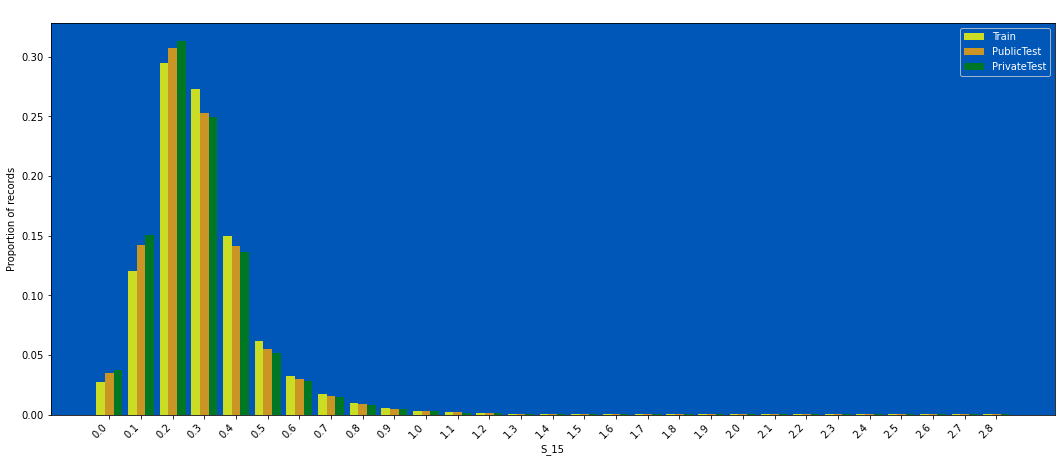

In [117]:
plot_train_test_distribution(df_list, "S_15", nunique_thr=500, without_drop_tail=True)

### S_16

In [118]:
# plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [119]:
%%time
df_list = round_dfs(df_list, col="S_16", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1060
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1048
CPU times: user 2.33 s, sys: 1.11 s, total: 3.45 s
Wall time: 4.04 s


In [120]:
# plot_target_check(train, "S_16", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [121]:
for df in df_list:
    df["S_16"] = np.where(df["S_16"] > 0, 1, 0)

In [122]:
# plot_train_test_distribution(df_list, "S_16", nunique_thr=5000)

### S_17 (Drop)

In [123]:
# plot_target_check(train, "S_17", q=50, use_raw_bin=True)

In [124]:
%%time
df_list = round_dfs(df_list, col="S_17", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0465
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0461
CPU times: user 2.05 s, sys: 1.11 s, total: 3.16 s
Wall time: 4.12 s


In [125]:
# plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [126]:
df_list = fill_nans(df_list, col="S_17", method="point", tuple_of_values=(0), add_new_col=False)

In [127]:
# plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

Train-Public PSI: 0.0158, Train-Private PSI: 0.0649


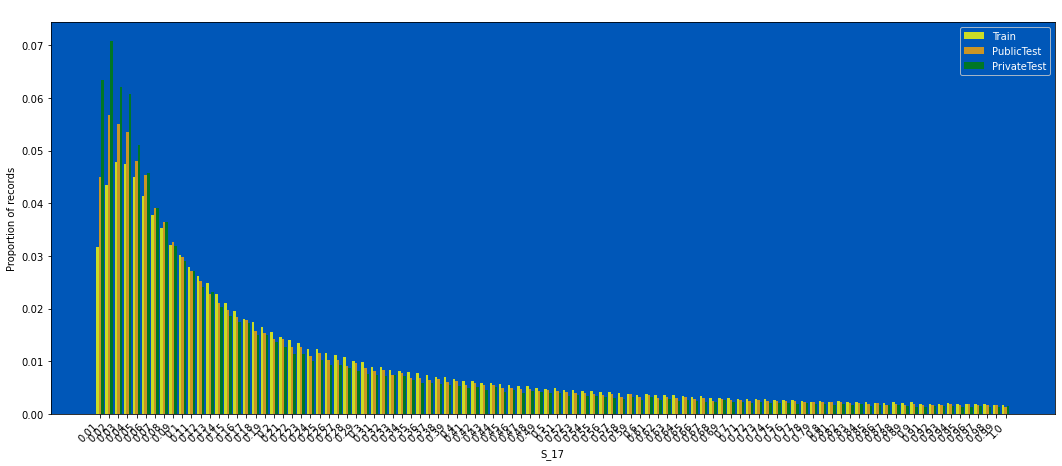

In [128]:
plot_train_test_distribution(
    [
        train.loc[train["S_17"] <= 1], 
        public_test.loc[public_test["S_17"] <= 1],
        private_test.loc[private_test["S_17"] <= 1]
    ],
    "S_17", 
    nunique_thr=15000,
    without_drop_tail=True
)

**Train Test Skew: Heavy**

### S_18 (Done)

In [129]:
# plot_target_check(train, "S_18", q=50, use_raw_bin=True)

In [130]:
%%time
df_list = round_dfs(df_list, col="S_18", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0001
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0001
CPU times: user 1.98 s, sys: 1.06 s, total: 3.04 s
Wall time: 3.96 s


In [131]:
# plot_target_check(train, "S_18", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True, without_drop_tail=True)

In [132]:
# plot_train_test_distribution(df_list, "S_18", nunique_thr=150, without_drop_tail=True)

### S_19 (Drop)

In [133]:
# plot_target_check(train, "S_19", q=50, use_raw_bin=True)

In [134]:
%%time
df_list = round_dfs(df_list, col="S_19", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0502
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0117
CPU times: user 1.98 s, sys: 1.16 s, total: 3.14 s
Wall time: 4.07 s


In [135]:
for df in df_list:
    print(df["S_19"].mean())

2.7790176573923133e-05
2.6741993006693942e-05
2.6708393770487004e-05


In [136]:
%%time
for df in df_list:
    df.drop(columns=["S_19"], inplace=True)

CPU times: user 696 ms, sys: 1.13 s, total: 1.82 s
Wall time: 1.82 s


### S_20 (Done)

In [137]:
# plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=200)

In [138]:
%%time
df_list = round_dfs(df_list, col="S_20", decimals=1, add_new_col=False)

Before round, Train-Private PSI = 0.0010
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0010
CPU times: user 2.04 s, sys: 1.14 s, total: 3.17 s
Wall time: 4.16 s


In [139]:
# plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=2000, without_drop_tail=True)

In [140]:
# plot_train_test_distribution(df_list, "S_20", nunique_thr=50, without_drop_tail=True)

### S_22 (Done)

In [141]:
# plot_target_check(train, "S_22", q=50, use_raw_bin=True)

In [142]:
%%time
df_list = round_dfs(df_list, col="S_22", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1080
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1141
CPU times: user 2.29 s, sys: 1.15 s, total: 3.45 s
Wall time: 4.39 s


19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


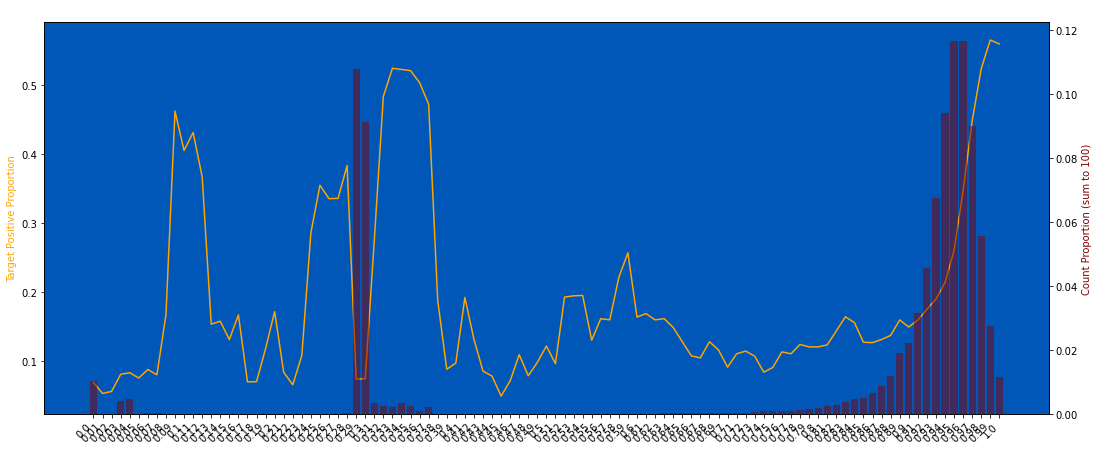

In [143]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True, nunique_thr=777, strfy_x=True)

Train-Public PSI: 0.1086, Train-Private PSI: 0.1141
Bottom 1% and Top 1% are dropped from this chart


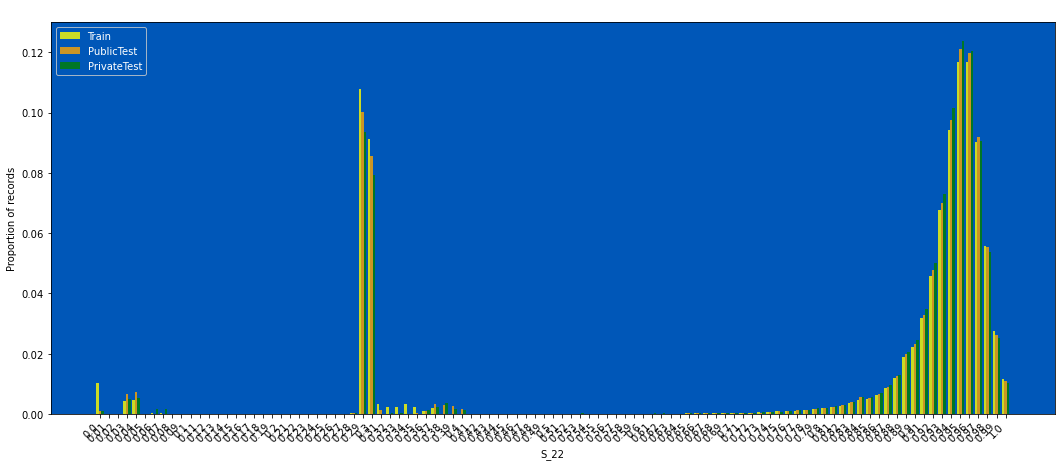

In [144]:
plot_train_test_distribution(df_list, "S_22", nunique_thr=777)

**Comments:**
- **Train Test Skew: Moderate**
- Relationship is ambigious

### S_23

In [145]:
# plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [146]:
%%time
df_list = round_dfs(df_list, col="S_23", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0573
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0573
CPU times: user 2.12 s, sys: 1.11 s, total: 3.22 s
Wall time: 4.19 s


445 null count, 0.000 null proportion
0.5236 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


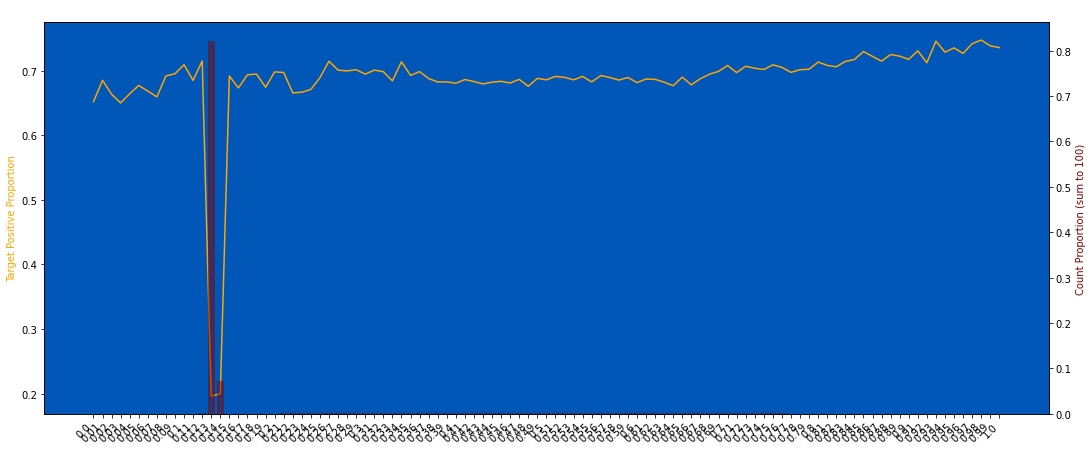

In [147]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

**ToDo:**
- Identify the subset of 0.13 & 0.14 to be replace by NaN

Train-Public PSI: 0.0531, Train-Private PSI: 0.0573
Bottom 1% and Top 1% are dropped from this chart


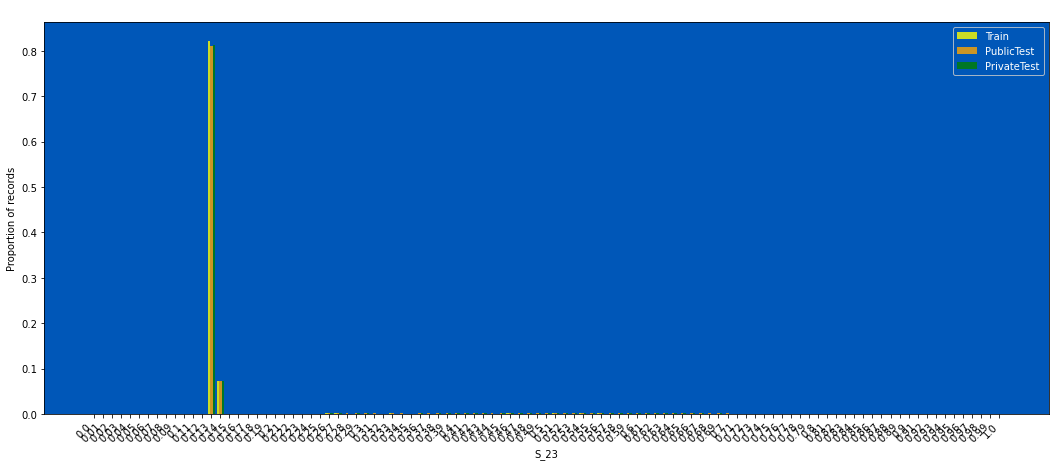

In [148]:
plot_train_test_distribution(df_list, "S_23", nunique_thr=1600)

### S_24 (Create & Drop)

In [149]:
# plot_target_check(train, "S_24", q=50, use_raw_bin=True)

In [150]:
%%time
df_list = round_dfs(df_list, col="S_24", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0762
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0778
CPU times: user 2.29 s, sys: 1.12 s, total: 3.41 s
Wall time: 4.34 s


18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


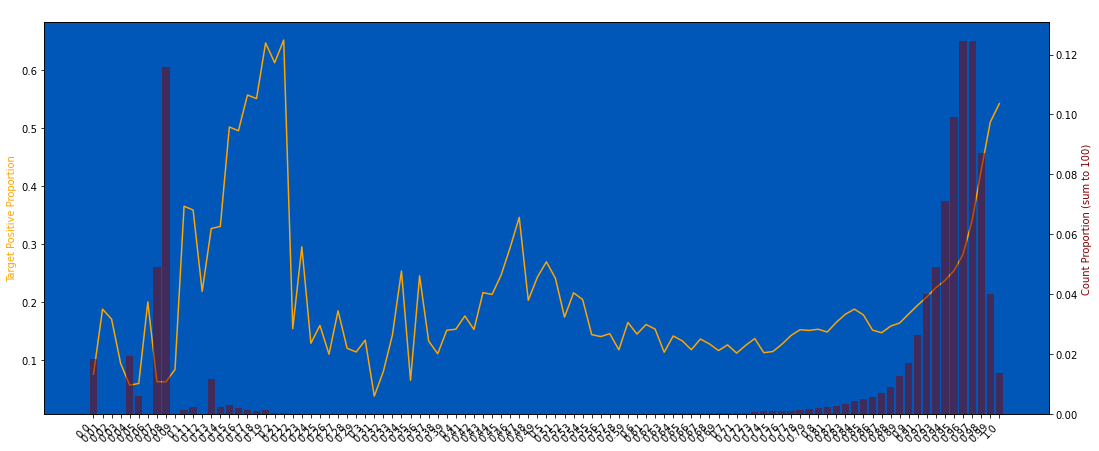

In [151]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True, nunique_thr=650, strfy_x=True)

Train-Public PSI: 0.0664, Train-Private PSI: 0.0778
Bottom 1% and Top 1% are dropped from this chart


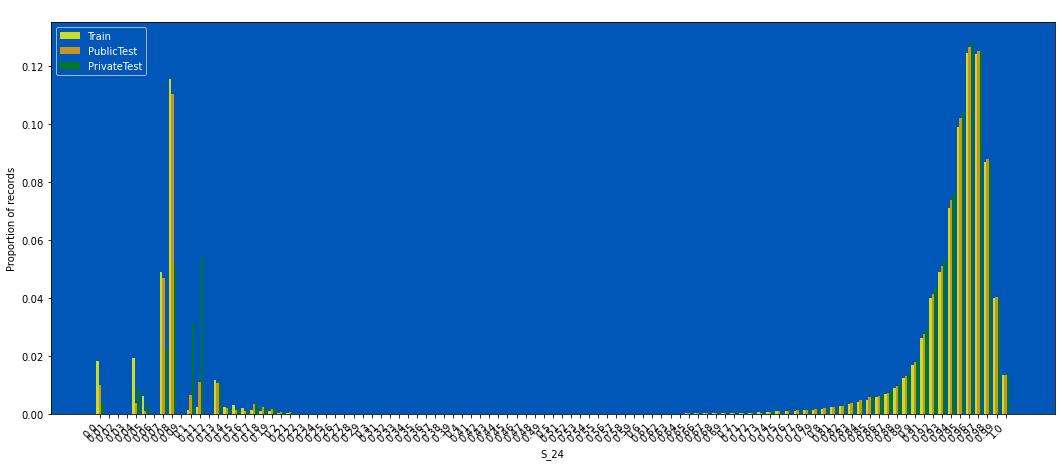

In [152]:
plot_train_test_distribution(df_list, "S_24", nunique_thr=650)

**Train Test Skew: Heavy**

### S_25

In [153]:
# plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [154]:
%%time
df_list = round_dfs(df_list, col="S_25", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0591
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0384
CPU times: user 2.15 s, sys: 1.15 s, total: 3.3 s
Wall time: 4.21 s


12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


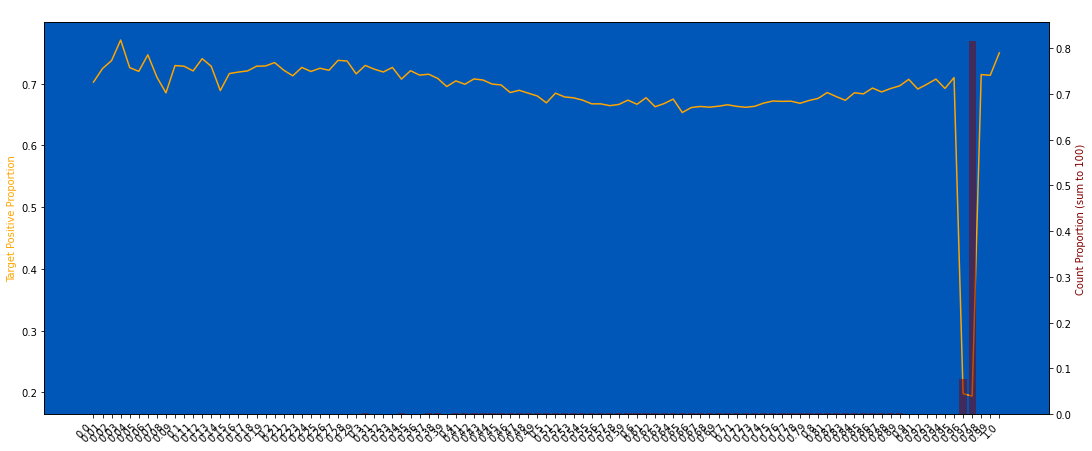

In [155]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Train-Public PSI: 0.0302, Train-Private PSI: 0.0384
Bottom 1% and Top 1% are dropped from this chart


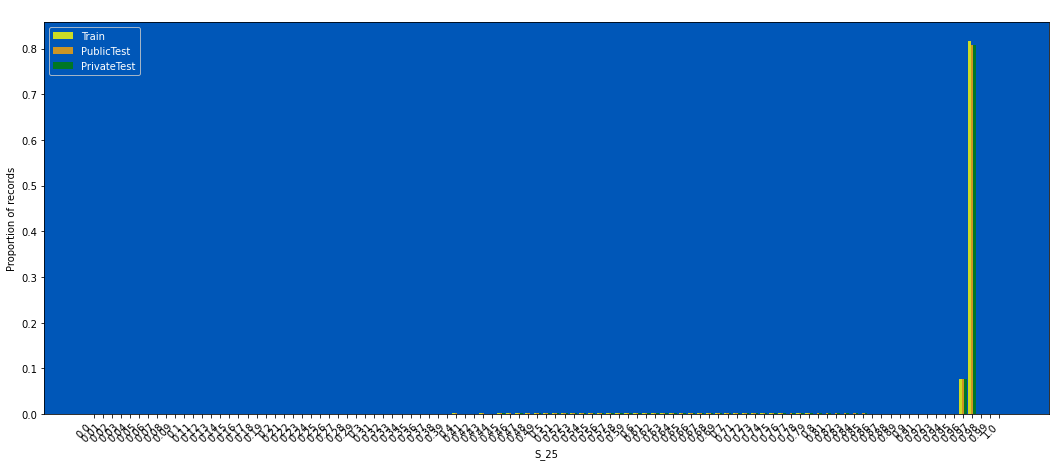

In [156]:
plot_train_test_distribution(df_list, "S_25", nunique_thr=1500)

**Train Test Skew: Moderate**

**ToDo:**
- Identify the subset of 0.97 & 0.98 to be replace by NaN

### S_26

In [157]:
# plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [158]:
%%time
df_list = round_dfs(df_list, col="S_26", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1113
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1128
CPU times: user 2.08 s, sys: 1.11 s, total: 3.19 s
Wall time: 4.11 s


634 null count, 0.000 null proportion
0.1325 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


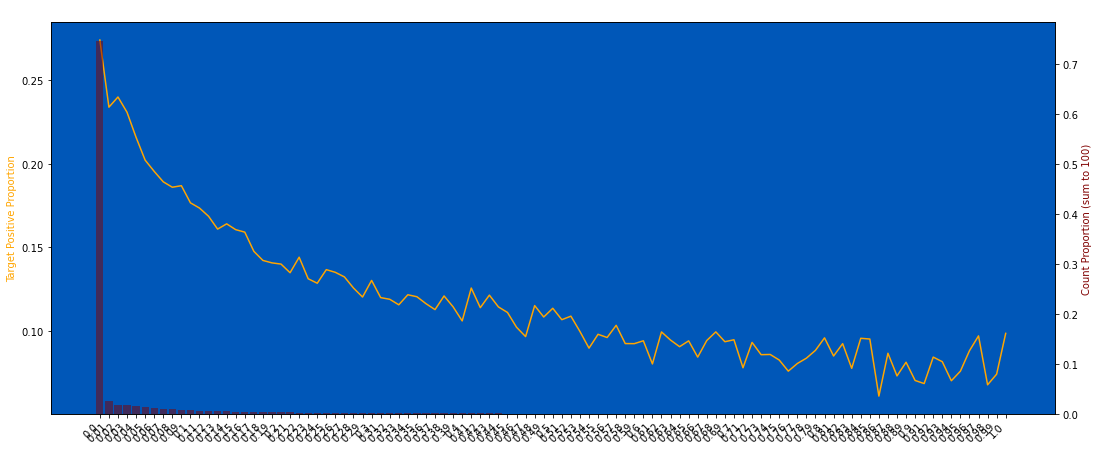

In [159]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Train-Public PSI: 0.1214, Train-Private PSI: 0.1128
Bottom 1% and Top 1% are dropped from this chart


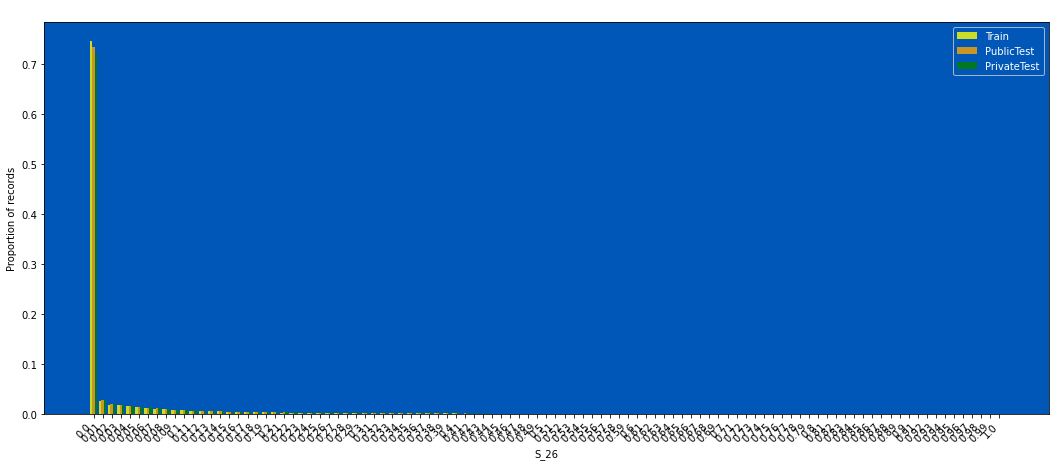

In [160]:
plot_train_test_distribution(df_list, "S_26", nunique_thr=2000)

### S_27

In [161]:
# plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [162]:
%%time
df_list = round_dfs(df_list, col="S_27", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1126
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1025
CPU times: user 2.07 s, sys: 1.19 s, total: 3.26 s
Wall time: 4.45 s


1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


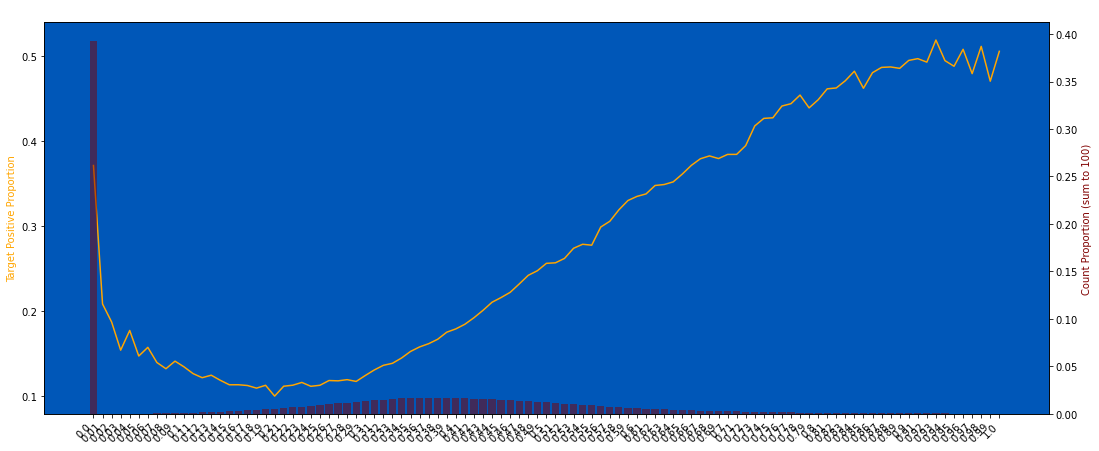

In [163]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

**ToDo:**
- Impute, then set 0 & 0.01 as NaN??

Train-Public PSI: 0.0967, Train-Private PSI: 0.1025
Bottom 1% and Top 1% are dropped from this chart


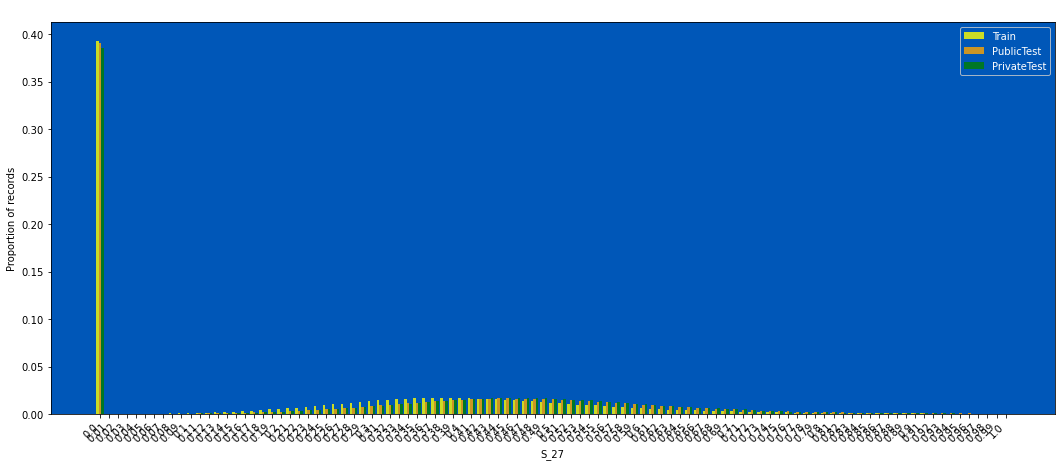

In [164]:
plot_train_test_distribution(df_list, "S_27", nunique_thr=1500)

**Train Test Skew: Heavy**

## Spike fix

S_12
0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


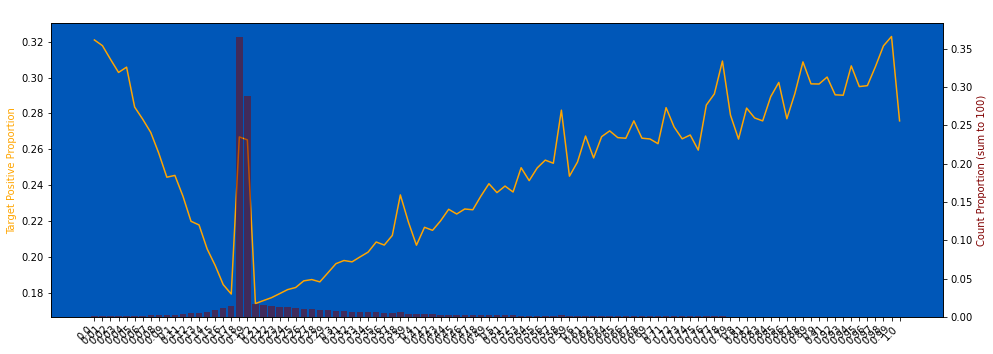

S_23
445 null count, 0.000 null proportion
0.5236 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


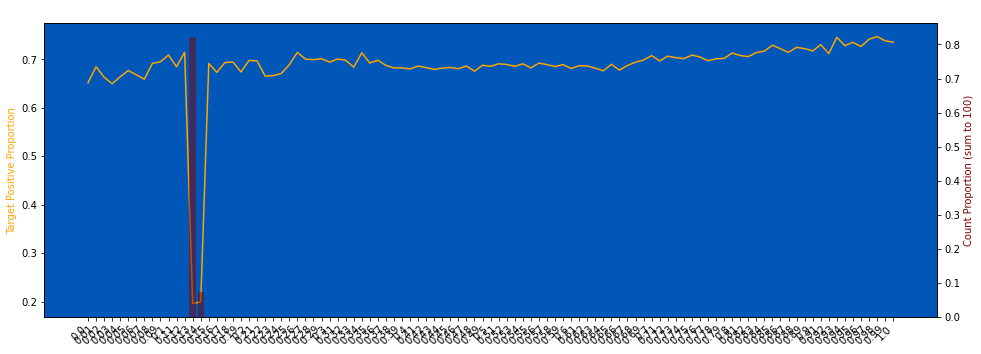

S_25
12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


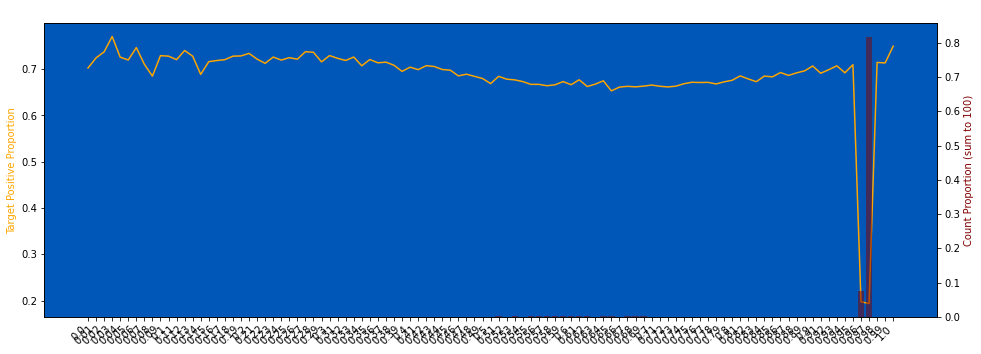

In [165]:
for col in ["S_12", "S_23", "S_25"]:
    print(col)
    plot_target_check(train, col, q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, figsize=(16, 6))

In [166]:
train["S_12_"] = train["S_12"].values

### S_12

In [167]:
special_indices = train.loc[
    (train["S_12"].between(0.18, 0.19))
    & 
    (
        (train["S_23"].between(0.13, 0.14))
        | (train["S_25"].between(0.96, 0.97))
        | (train["S_22"].between(0.3, 0.31))
    )
    
].index.tolist()

In [168]:
train.loc[special_indices, "S_12"] = np.nan

3251938 null count, 0.588 null proportion
0.2134 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


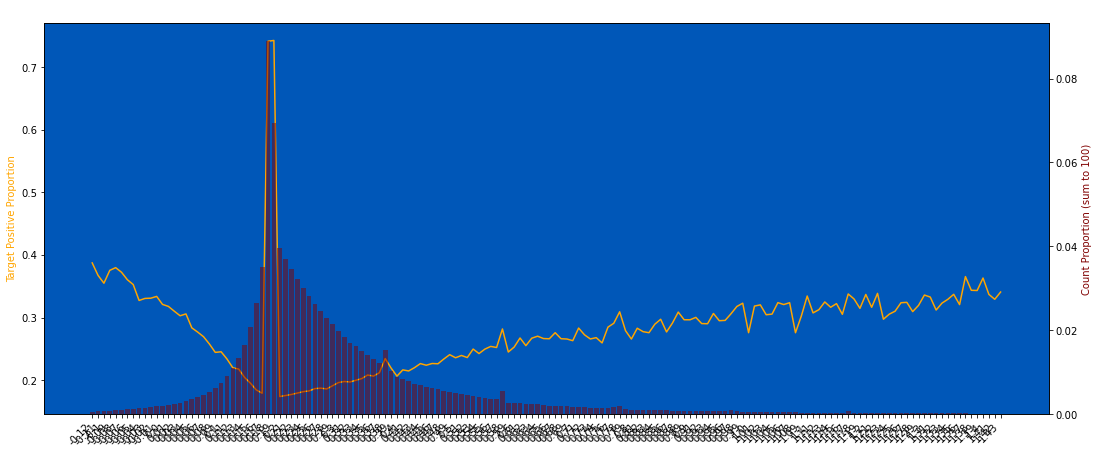

In [169]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

### S_23

In [170]:
special_indices = train.loc[
    (train["S_23"].between(0.13, 0.14))
    & 
    (
        (train["S_12"].isnull())
        | (train["S_22"].between(0.3, 0.31))
        | (train["S_25"].between(0.96, 0.97))
    )
    
].index.tolist()

In [171]:
train.loc[special_indices, "S_23"] = np.nan

4939301 null count, 0.893 null proportion
0.1957 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


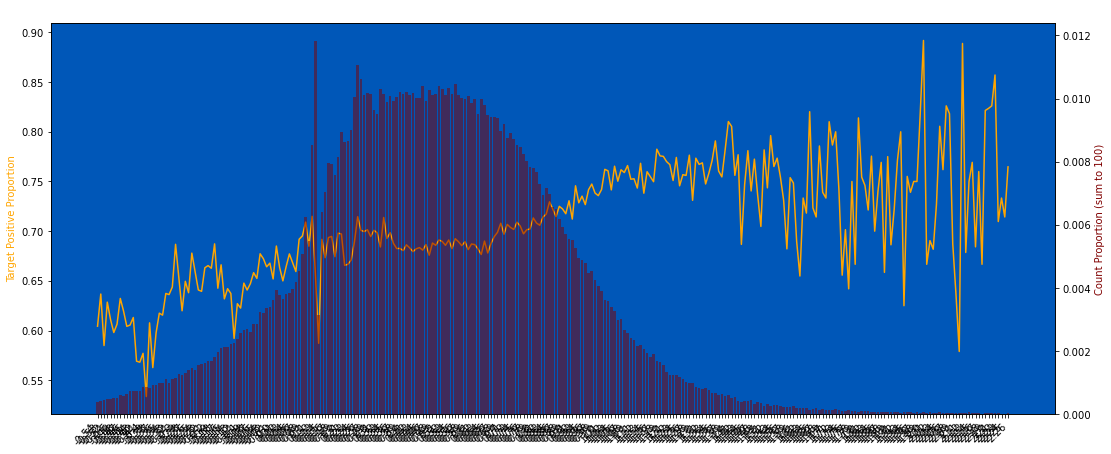

In [172]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

### S_25

In [173]:
special_indices = train.loc[
    (train["S_25"].between(0.96, 0.97))
    & 
    (
        (train["S_12"].isnull())
        | (train["S_22"].between(0.3, 0.31))
        | (train["S_23"].isnull())
    )
    
].index.tolist()

In [174]:
train.loc[special_indices, "S_25"] = np.nan

4934580 null count, 0.892 null proportion
0.1948 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


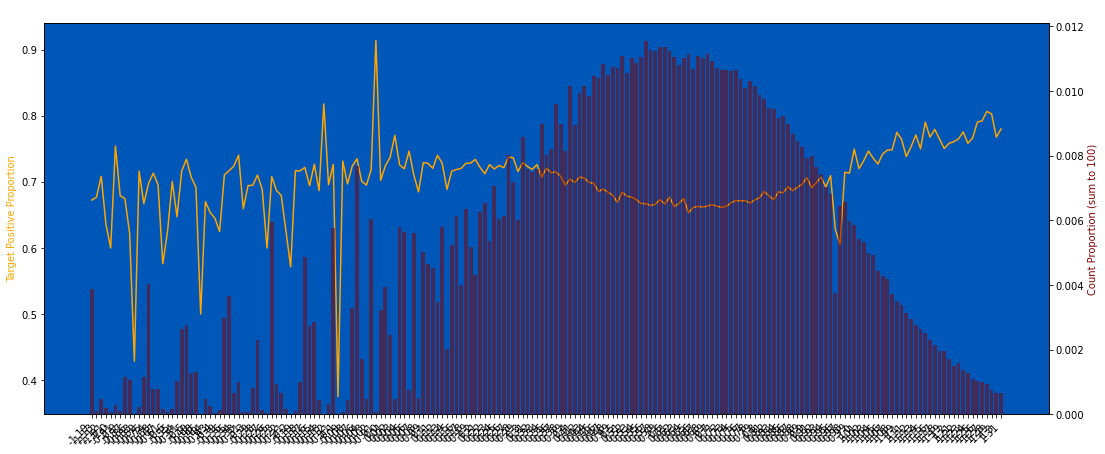

In [175]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [176]:
END = time.time()

In [177]:
print(f"{END - START:.2f} seconds elapsed")

245.74 seconds elapsed


### Extra Columns (Feature Crossing)

#### S_3 vs S_7

In [178]:
# for df in df_list:
#     df["S_37d"] = (df["S_3"] - df["S_7"]).round(2)
#     df["S_37m"] = 0.5 * (df["S_3"] + df["S_7"]).round(2)

#### S_22 vs S_24

In [179]:
# for df in df_list:
#     df["S_2224d"] = (df["S_22a"] - df["S_24a"]).round(2)
#     df["S_2224m"] = 0.5 * (df["S_22a"] + df["S_24a"]).round(2)

### Column checking

In [180]:
from tqdm import tqdm

In [181]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp', 'S_11_', 'S_13_', 'S_12_']

In [182]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s]

CPU times: user 660 ms, sys: 1.03 s, total: 1.69 s
Wall time: 1.69 s


In [183]:
all_columns = get_cols(df_list[0], ("S_", "P_"))
print(all_columns)

['S_2', 'P_2', 'S_3', 'P_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'P_4', 'S_16', 'S_17', 'S_18', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'P_3a', 'S_3a', 'S_7a']


In [184]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()
# for d in less_unique_d_cols:
#     if df_list[0][d].dtype != np.int32:
#         print(d, ":", df_list[0][d].dtype, "\n", sorted(df_list[0][d].unique().tolist()), "\n")

In [185]:
print(less_unique_d_cols)

['S_6', 'S_8', 'S_11', 'S_13', 'S_15', 'P_4', 'S_16', 'S_18', 'S_20']


In [186]:
for col in tqdm(less_unique_d_cols):
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

  0%|                                                                                                                                                | 0/9 [00:00<?, ?it/s]

S_6 fulfill criteria to convert to integer
S_11 fulfill criteria to convert to integer


 33%|█████████████████████████████████████████████▎                                                                                          | 3/9 [00:00<00:01,  5.50it/s]

S_13 fulfill criteria to convert to integer


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7/9 [00:01<00:00,  6.24it/s]

S_16 fulfill criteria to convert to integer
S_18 fulfill criteria to convert to integer


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8/9 [00:01<00:00,  4.46it/s]

S_20 fulfill criteria to convert to integer


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.10it/s]


In [187]:
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

P_2 fulfill criteria to convert to float32
S_3 fulfill criteria to convert to float32
P_3 fulfill criteria to convert to float32
S_5 fulfill criteria to convert to float32
S_7 fulfill criteria to convert to float32
S_8 fulfill criteria to convert to float32
S_12 fulfill criteria to convert to float32
S_15 fulfill criteria to convert to float32
P_4 fulfill criteria to convert to float32
S_17 fulfill criteria to convert to float32
S_22 fulfill criteria to convert to float32
S_23 fulfill criteria to convert to float32
S_24 fulfill criteria to convert to float32
S_25 fulfill criteria to convert to float32
S_26 fulfill criteria to convert to float32
S_27 fulfill criteria to convert to float32
P_3a fulfill criteria to convert to float32
S_3a fulfill criteria to convert to float32
S_7a fulfill criteria to convert to float32


In [188]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 4.29 s, sys: 954 ms, total: 5.25 s
Wall time: 5.26 s


In [189]:
train.shape, test.shape

((5531451, 30), (11363762, 29))

In [190]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.578975071, 2.784121834)

In [191]:
train.columns

Index(['customer_ID', 'row_number', 'row_number_inv', 'S_2', 'P_2', 'S_3',
       'P_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15',
       'P_4', 'S_16', 'S_17', 'S_18', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25',
       'S_26', 'S_27', 'target', 'P_3a', 'S_3a', 'S_7a'],
      dtype='object')

In [192]:
%%time
train.to_parquet(f"./train_parquet/train_spend_payment_.parquet")
test.to_parquet(f"./test_parquet/test_spend_payment_.parquet")

CPU times: user 9.02 s, sys: 687 ms, total: 9.7 s
Wall time: 9.07 s
